In [1]:
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

## Загрузка и предобработка

In [3]:
data_full = pd.read_csv(r'D:\PC\Downloads\test (1).csv', parse_dates=[0])

data = data_full.drop(columns=['events_ordinal_number',
                               'second_event_time',
                               'loan_ordinal_number',
                               'events_time_diff',
                               'previous_loans_max_amount'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      10000 non-null  datetime64[ns]
 1   user_id   10000 non-null  int64         
 2   type      10000 non-null  object        
 3   amount    10000 non-null  int64         
 4   target    2061 non-null   float64       
 5   feature1  10000 non-null  int64         
 6   feature2  10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 547.0+ KB


In [5]:
for col in ['type', 'target', 'feature1', 'feature2']:
    print(data[col].value_counts())
    print()

loanRequest    7939
loan           2061
Name: type, dtype: int64

0.0    1075
1.0     986
Name: target, dtype: int64

1    6000
0    4000
Name: feature1, dtype: int64

1    5000
0    5000
Name: feature2, dtype: int64



В таргете присуствуют пропуски, предположу, что это равноценно нулевым значениям, потому заполню нулями.

In [6]:
# Заполнение таргета нулями, приведение его в целочисленное
data['target'] = data['target'].fillna(0).astype(int)

# Приведение типа заявки в целочисленное
data['type'] = data['type'].apply(lambda x: 1 if x=='loan' else 0)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      10000 non-null  datetime64[ns]
 1   user_id   10000 non-null  int64         
 2   type      10000 non-null  int64         
 3   amount    10000 non-null  int64         
 4   target    10000 non-null  int32         
 5   feature1  10000 non-null  int64         
 6   feature2  10000 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5)
memory usage: 507.9 KB


## Проверка важности фичей

В качестве быстрой и простой проверки обучу три модели классификаторов и проверю значимости признаков, которую они выдают.

In [8]:
test = data.drop(columns=['time', 'user_id'])

train = test.drop(columns='target')
target = test['target']

In [9]:
def check_imortances(model):
    model.fit(train, target)
    plt.bar(train.columns, model.feature_importances_)
    plt.show()
    
models = [LGBMClassifier(importance_type='gain'),
          XGBClassifier(importance_type='gain', eval_metric='logloss'),
          RandomForestClassifier()]

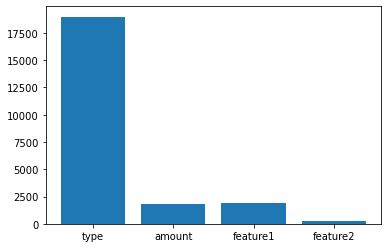

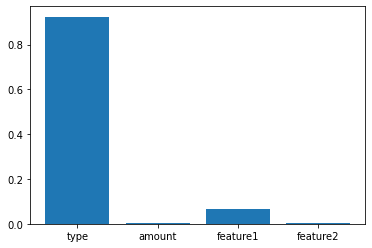

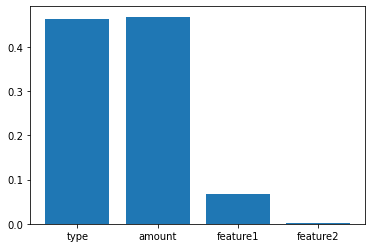

In [10]:
for model in models:
    check_imortances(model)

Смотря на графики можно сделать вывод, что **feature2** не приносит практически никакой пользы для определения целевой переменной, ее можно удалить.  
В свою очередь **feature1** имеет так же довольно слабую значимость, но не околонулевую. Эту фичу так же можно спокойно удалить с целью уменьшения размерности, если важна скорость работы, а не максимальная точность модели.

## Генерация фичей
### Порядковые номера событий

In [11]:
dict = {} # Словарь для хранения количества событий по каждому user_id

def ordinal_events(row):
    if row in dict.keys():
        dict[row] += 1
    else:
        dict[row] = 1
    return dict[row]

# Примененение функции и проверка на одном юзере
data['events_ordinal_number'] = data['user_id'].apply(ordinal_events)
data.query('user_id == 666')

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number
1226,2001-02-21 02:00:00,666,1,15683,1,1,1,1
2622,2001-04-20 06:00:00,666,0,15022,0,1,1,2
3518,2001-05-27 14:00:00,666,0,15304,0,1,0,3
4498,2001-07-07 10:00:00,666,0,15197,0,0,1,4
6911,2001-10-15 23:00:00,666,0,16122,0,0,1,5
7876,2001-11-25 04:00:00,666,0,14934,0,1,1,6
8466,2001-12-19 18:00:00,666,1,12791,1,1,1,7
9538,2002-02-02 10:00:00,666,0,15692,0,0,1,8


### Время последнего события
Немного смутило название столбца **second_event_time** и описание в письме "время второго события".  
Просматривая присланный заполненный датасет я пришел к выводу, что **second_event_time** отображает время самой последней отметки клиента в базе данных.

In [12]:
dict = {}

def last_event(row):
    id = row['user_id']
    
    dict[id] = data[data['user_id'] == id]['time'].max()
    return dict[id]

data['second_event_time'] = data.apply(last_event, axis=1)
data.query('user_id == 666')

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time
1226,2001-02-21 02:00:00,666,1,15683,1,1,1,1,2002-02-02 10:00:00
2622,2001-04-20 06:00:00,666,0,15022,0,1,1,2,2002-02-02 10:00:00
3518,2001-05-27 14:00:00,666,0,15304,0,1,0,3,2002-02-02 10:00:00
4498,2001-07-07 10:00:00,666,0,15197,0,0,1,4,2002-02-02 10:00:00
6911,2001-10-15 23:00:00,666,0,16122,0,0,1,5,2002-02-02 10:00:00
7876,2001-11-25 04:00:00,666,0,14934,0,1,1,6,2002-02-02 10:00:00
8466,2001-12-19 18:00:00,666,1,12791,1,1,1,7,2002-02-02 10:00:00
9538,2002-02-02 10:00:00,666,0,15692,0,0,1,8,2002-02-02 10:00:00


### Номер займа

In [13]:
dict = {}

def loan_number(row):
    id = row['user_id']
    type = row['type']

    if (id not in dict.keys()) and (type == 0):
        dict[id] = 1
    if (id not in dict.keys()) and (type == 1):
        dict[id] = 2
        return dict[id] - 1
    elif (id in dict.keys()) and (type == 1):
        dict[id] += 1
        return dict[id] - 1
    return dict[id]


data['loan_ordinal_number'] = data.apply(loan_number, axis=1)
data.query('user_id == 666')

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number
1226,2001-02-21 02:00:00,666,1,15683,1,1,1,1,2002-02-02 10:00:00,1
2622,2001-04-20 06:00:00,666,0,15022,0,1,1,2,2002-02-02 10:00:00,2
3518,2001-05-27 14:00:00,666,0,15304,0,1,0,3,2002-02-02 10:00:00,2
4498,2001-07-07 10:00:00,666,0,15197,0,0,1,4,2002-02-02 10:00:00,2
6911,2001-10-15 23:00:00,666,0,16122,0,0,1,5,2002-02-02 10:00:00,2
7876,2001-11-25 04:00:00,666,0,14934,0,1,1,6,2002-02-02 10:00:00,2
8466,2001-12-19 18:00:00,666,1,12791,1,1,1,7,2002-02-02 10:00:00,2
9538,2002-02-02 10:00:00,666,0,15692,0,0,1,8,2002-02-02 10:00:00,3


### Разница во времени между отметками в базе

In [14]:
dict = {}

def time_delta(row):
    id = row['user_id']
    new_time = row['time']

    if id in dict.keys():
        delta = new_time - dict[id]
        dict[id] = new_time
        return delta
    else:
        dict[id] = new_time
        return None

data['events_time_diff'] = data.apply(time_delta, axis=1)
data.query('user_id == 777')

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number,events_time_diff
1806,2001-03-17 06:00:00,777,0,14673,0,1,1,1,2001-09-27 09:00:00,1,NaT
3016,2001-05-06 16:00:00,777,0,13825,0,0,0,2,2001-09-27 09:00:00,1,50 days 10:00:00
5904,2001-09-04 00:00:00,777,0,15216,0,1,1,3,2001-09-27 09:00:00,1,120 days 08:00:00
6333,2001-09-21 21:00:00,777,1,14331,1,1,0,4,2001-09-27 09:00:00,1,17 days 21:00:00
6465,2001-09-27 09:00:00,777,0,15788,0,0,1,5,2001-09-27 09:00:00,2,5 days 12:00:00


### Максимальная сумма предыдущего займа

In [15]:
dict = {}

def max_loan(row):
    id = row['user_id']
    type = row['type']
    amount = row['amount']

    if type == 1:   # Если запись о займе
        if id in dict.keys():
            if amount > dict[id]:
                previous = dict[id]
                dict[id] = amount
                return previous    # Обновляет максимальное значение, но возаращает предыдущее максимальное
            else:
                return dict[id]
        else:
            dict[id] = amount
            return None    # Создает новую запись о займе, но возвращает пропуск
        
    else:   # Если запись о заявке на займ
        if id in dict.keys():
            return dict[id]
        else:
            return None

data['previous_loans_max_amount'] = data.apply(max_loan, axis=1)
data.query('user_id == 400')

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number,events_time_diff,previous_loans_max_amount
2503,2001-04-15 07:00:00,400,1,14052,0,1,1,1,2002-02-14 02:00:00,1,NaT,NaN
2697,2001-04-23 09:00:00,400,1,14926,0,0,1,2,2002-02-14 02:00:00,2,8 days 02:00:00,14052.0
2925,2001-05-02 21:00:00,400,1,14968,1,1,0,3,2002-02-14 02:00:00,3,9 days 12:00:00,14926.0
4956,2001-07-26 12:00:00,400,0,14351,0,1,1,4,2002-02-14 02:00:00,4,84 days 15:00:00,14968.0
6745,2001-10-09 01:00:00,400,0,16629,0,1,0,5,2002-02-14 02:00:00,4,74 days 13:00:00,14968.0
7411,2001-11-05 19:00:00,400,0,15578,0,0,1,6,2002-02-14 02:00:00,4,27 days 18:00:00,14968.0
7783,2001-11-21 07:00:00,400,0,13117,0,0,1,7,2002-02-14 02:00:00,4,15 days 12:00:00,14968.0
9170,2002-01-18 02:00:00,400,0,14229,0,1,1,8,2002-02-14 02:00:00,4,57 days 19:00:00,14968.0
9818,2002-02-14 02:00:00,400,0,14810,0,0,0,9,2002-02-14 02:00:00,4,27 days 00:00:00,14968.0
